In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pandas as pd

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, Layer
from keras.datasets import mnist
from keras.utils import to_categorical

import keras.backend as K

from vae_utils import *

Using TensorFlow backend.


In [3]:
os.chdir('./data/vae')

# Data

In [4]:
def preprocess(data):
    x, y = data
    x = x.reshape((len(x), 28, 28))
    x = x/255.
    #y = to_categorical(y, 10) #don't need to categorise y
    return x, y

train, test = mnist.load_data()

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

print(x_train.shape)

(60000, 28, 28)


# Model

In [9]:
# VAE model from "Auto Encoding Variation Bayes": https://arxiv.org/pdf/1312.6114.pdf
# encoder model is modelled by a gaussian, producing the latent
# variables mean and its log standard deviation


def encoder_model(latent_dim, hidden_dim=200):
    enc_in = Input(shape=(28,28), name='enc_input')
    enc_flat = Flatten(name='enc_flatten')(enc_in)
    enc_hid = Dense(hidden_dim, activation='relu', name='enc_hidden')(enc_flat)
    #enc_hid2 = Dense(hidden_dim, activation='relu', name='enc_hidden2')(enc_hid)
    z_mean = Dense(latent_dim, name='latent_mean')(enc_hid)
    log_z_var = Dense(latent_dim, name='log_latent_var')(enc_hid)
    enc_model = Model(enc_in, [z_mean, log_z_var], name='encoder_model')
    return enc_model, (z_mean, log_z_var)

# from the paper, we can either model the decoder p(x|z) as a bernoulli distribution, 
# or as a gaussian distribution, we'll try both

def bernoulli_decoder(latent_dim, hidden_dim=200):
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')(dec_in)
    #dec_hid2 = Dense(hidden_dim, activation='relu', name='dec_hidden2')(dec_hid)
    dec_flat = Dense(28*28, activation='sigmoid', name='dec_flat')(dec_hid)
    dec_out = Reshape((28, 28), name='dec_out')(dec_flat)
    dec_model = Model(dec_in, dec_out, name='decoder_model')
    return dec_model

def gauss_decoder(latent_dim, hidden_dim=200):
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')(dec_in)
    dec_mean = Dense(28*28, name='dec_mean')(dec_hid)
    log_dec_var = Dense(28*28, name='log_dec_var')(dec_hid)
    dec_model = Model(dec_in, [dec_mean, log_dec_var], name='decoder_model')
    return dec_model

# we need a layer that samples a latent variable given a mean and standard deviation

class Sampler(Layer):
    
    def __init__(self, **kwargs):
        self.stddev = 1
        super(Sampler, self).__init__(**kwargs)
    
    def call(self, x, training=None):
        assert isinstance(x, list)
        z_mean, log_z_var = x
        z_std = K.exp(log_z_var/2)
        # sample epsilon from N(0, stddev)
        shape = K.shape(z_std)
        epsilon = K.random_normal(shape, mean=0, stddev=self.stddev)
        # we sample during training only
        z_sample = z_mean + z_std * epsilon
        return K.in_train_phase(z_sample, z_mean, training=training)
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        assert input_shape[0] == input_shape[1]
        return input_shape[0]

# Bernoulli Model

In [10]:
latent_dim = 2
hidden_dim = 200

enc_model, (z_mean, log_z_var) = encoder_model(latent_dim, hidden_dim)
dec_model = bernoulli_decoder(latent_dim, hidden_dim)

# make the z_sampler layer to connect the decoder and encoder
z_sampler = Sampler(name='z_sampler')([z_mean, log_z_var])
# connect the encoder and decoder
enc_dec_model = Model(enc_model.input, dec_model(z_sampler))

# elbo loss
def bernoulli_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.sum(1 + log_z_var - K.square(z_mean) - K.exp(log_z_var), axis=-1)
    im_loss = K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2)) # computes -log p(x|z)
    return kl_loss + im_loss

enc_dec_model.compile(optimizer='adam', loss=bernoulli_loss)

# train and save the model
epochs = 30
batch_size = 256

dec_path = './dec_model_%d_dim.weights' %latent_dim
weights_path = './enc_dec_model_%d_dim.weights' %latent_dim
loss_path = './training_loss_%d_dim.png' %latent_dim

"""
if not os.path.exists(weights_path):
    # training
    history = enc_dec_model.fit(
        x=x_train, y=x_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, x_test)
    )
    # enc_dec_model represents the whole dec_model as a single layer
    # so we have to save the decoder weights seperately
    dec_model.save_weights(dec_path) # hacky fix for decoder weights
    enc_dec_model.save_weights(weights_path)
    # plotting
    plot([-x for x in history.history['loss']])
    xlabel('Epoch')
    ylabel('ELBO')
    ylim(-200, -90)
    gcf().savefig(loss_path, bbox_inches='tight')
    print('Model Saved')
else:
    dec_model.load_weights(dec_path, by_name=True)
    enc_model.load_weights(weights_path, by_name=True)
    enc_dec_model.load_weights(weights_path, by_name=True)
    print('Model Loaded')
"""

enc_dec_model.fit(
        x=x_train, y=x_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 4s 74us/step - loss: 233.5228 - val_loss: 189.1262
Epoch 2/30
60000/60000 [==============================] - 4s 61us/step - loss: 184.9050 - val_loss: 177.9138
Epoch 3/30
60000/60000 [==============================] - 4s 60us/step - loss: 175.8703 - val_loss: 170.9313
Epoch 4/30
60000/60000 [==============================] - 4s 60us/step - loss: 170.3562 - val_loss: 167.6775
Epoch 5/30
60000/60000 [==============================] - 4s 60us/step - loss: 167.6783 - val_loss: 165.7055
Epoch 6/30
60000/60000 [==============================] - 4s 60us/step - loss: 166.1432 - val_loss: 164.6494
Epoch 7/30
60000/60000 [==============================] - 4s 63us/step - loss: 165.0003 - val_loss: 163.6290
Epoch 8/30
60000/60000 [==============================] - 4s 62us/step - loss: 164.0191 - val_loss: 162.8165
Epoch 9/30
60000/60000 [==============================] - 4s 71us/step - loss:

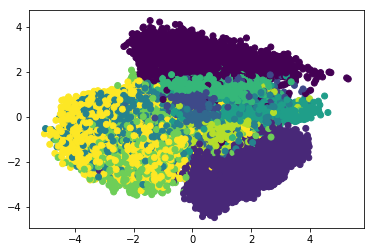

In [13]:
z_mean, log_z_var = enc_model.predict(x_train)
scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)

# Analysis

## Number of active units

In [7]:
z_mean, log_z_var = enc_model.predict(x_train)

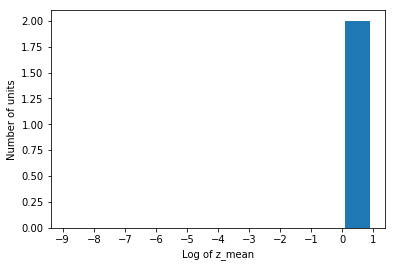

In [272]:
z_mean_var = var(z_mean, axis=0)

hist(log(z_mean_var), bins=range(-9, 2), rwidth=0.8)
xticks(range(-9, 2))
xlabel(r'Log of z_mean')
ylabel('Number of units')

active_path = './active_units_%d_dim.png' %latent_dim
gcf().savefig(active_path, bbox_inches='tight')

In [273]:
# make 10^-2 the cut off for the number of active units
# calculate the number of active units over the entire dataset

active = log(z_mean_var) > -2
nb_active = sum(active)

nb_active

2

In [274]:
# get the monte carlo samples if we've trained a new model
elbo_path = './mnist_elbos_%d_dim.csv' % latent_dim
if not os.path.exists(elbo_path):
    x_preds, z_samples = get_mc_samples(dec_model, enc_model, x_train)

    # make a table of the elbo values
    elbos = elbo(x_train, x_preds, enc_model)
    df_elbos = pd.DataFrame(elbos, columns=['elbo'])

    # add the std values to the elbo table
    V = calc_V(enc_model, x_train, x_preds, z_samples)
    V_square = V**2
    V_std = -1/2 * np.var(V, axis=0, ddof=1)

    df_elbos['elbo_var'] = V_std
    df_elbos.to_csv(elbo_path, index=False)
else:
    df_elbos = pd.read_csv(elbo_path)

df_elbos.head()

,elbo,elbo_var
0,-192.310920,-0.600928
1,-122.092670,-1.506634
2,-200.399942,-5.243822
3,-56.404273,-0.219760
4,-147.361245,-0.836321


In [275]:
label_active = []
for num in range(10):
    label_active.append(sum(log(var(z_mean[y_train==num], axis=0)) > -2))
    
df_label_active = pd.DataFrame(label_active, columns=['Active Units'])
df_label_active

,Active Units
0,2
1,2
2,1
3,2
4,2
5,2
6,2
7,2
8,2
9,2


In [276]:
# get the best encodings (elbo/std)
top = 100
(z_elbo_min, z_elbo_max), (z_std_min, z_std_max) = get_z_min_max(
    x_train, 
    y_train, 
    df_elbos['elbo'], 
    df_elbos['elbo_var'], 
    enc_model,
    top=top
)

In [277]:
# calculate the number of activation units in the best/worse case over all cases
max_elbo_cases = array([z_elbo_max[num] for num in range(10)])
min_elbo_cases = array([z_elbo_min[num] for num in range(10)])

max_std_cases = array([z_std_max[num] for num in range(10)])
min_std_cases = array([z_std_min[num] for num in range(10)])


max_elbo_var = var(np.concatenate(max_elbo_cases), axis=0)
min_elbo_var = var(np.concatenate(min_elbo_cases), axis=0)

max_std_var = var(np.concatenate(max_std_cases), axis=0)
min_std_var = var(np.concatenate(min_std_cases), axis=0)


max_elbo_active = sum(log(max_elbo_var) > -2)
min_elbo_active = sum(log(min_elbo_var) > -2)

max_std_active = sum(log(max_std_var) > -2)
min_std_active = sum(log(min_std_var) > -2)


print(max_elbo_active, min_elbo_active)
print(max_std_active, min_std_active)

2 2
2 2


In [278]:
# calculate the number of active units in the best/worst cases for each class
z_elbo_min_var = log(var(min_elbo_cases, axis=1))
z_elbo_max_var = log(var(max_elbo_cases, axis=1))

z_std_min_var = log(var(min_std_cases, axis=1))
z_std_max_var = log(var(max_std_cases, axis=1))


elbo_min_active = sum(z_elbo_min_var > -2, axis=-1)
elbo_max_active = sum(z_elbo_max_var > -2, axis=-1)

std_min_active = sum(z_std_min_var > -2, axis=-1)
std_max_active = sum(z_std_max_var > -2, axis=-1)

df_active = pd.DataFrame()

df_active['Worst Elbo'] = elbo_min_active
df_active['Best Elbo'] = elbo_max_active
df_active['Worst Var'] = std_min_active
df_active['Best Var'] = std_max_active

active_path = './active_labels_%d_dim.csv' %latent_dim
df_active.to_csv(active_path, index_label='Class')

df_active

,Worst Elbo,Best Elbo,Worst Var,Best Var
0,2,2,2,2
1,2,2,2,2
2,2,2,2,0
3,2,2,2,1
4,2,2,2,2
5,2,2,2,1
6,2,1,2,1
7,2,2,2,2
8,2,1,2,2
9,2,1,2,2


# Visualising

In [279]:
# Now visualise a (original/reconstruction) pair for
# each min elbo, max elbo, and approximate mean elbo
# for each label
image_pairs = get_image_pairs(x_train, y_train, df_elbos['elbo'], enc_dec_model)

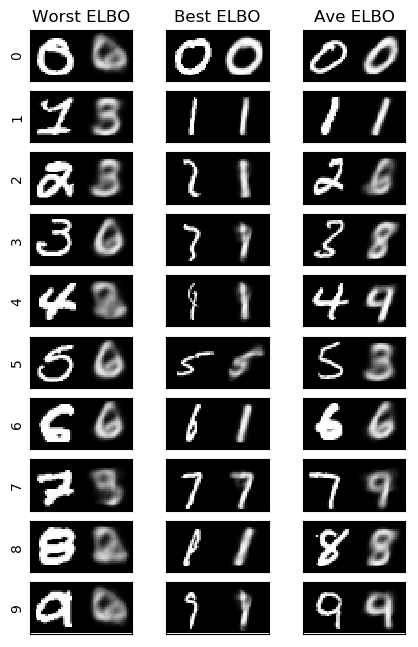

In [280]:
fig, axes = plot_min_max_mean('ELBO', image_pairs)

image_path = './mnist_images_elbo_%d_dim.png' %latent_dim
fig.savefig(image_path, bbox_inches='tight')

# Second order term

In [281]:
elbo_labels = []
y_df = pd.DataFrame(y_train, columns=['label'])

for num in range(10):
    idx = y_df[y_df['label'] == num].index
    df_nums = df_elbos.iloc[idx, 0]
    elbo_min = df_nums.min()
    elbo_max = df_nums.max()
    elbo_mean = mean(df_nums)
    
    df_std = df_elbos.iloc[idx, 1]
    std_min = df_std.min()
    std_max = df_std.max()
    std_mean = mean(df_std)
    elbo_labels.append([elbo_min, elbo_max, elbo_mean, std_min, std_max, std_mean])

# indices represent the number
df_elbo_labels = pd.DataFrame(
    elbo_labels, 
    columns=['Worst Elbo', 'Best Elbo', 'Mean Elbo', 'Worst Var', 'Best Var', 'Mean Var']
)

label_path = './mnist_labels_%d_dim.csv' %latent_dim
df_elbo_labels.to_csv(label_path, float_format='%.3f')

df_elbo_labels

,Worst Elbo,Best Elbo,Mean Elbo,Worst Var,Best Var,Mean Var
0,-418.667265,-108.182590,-170.536059,-104.037793,-0.002286,-2.584369
1,-270.097543,-42.240349,-67.500190,-58.853883,-0.002235,-0.762822
2,-369.264359,-105.066403,-198.672585,-129.516601,-0.004207,-2.222296
3,-330.201916,-87.902149,-172.674497,-59.453864,-0.003668,-1.460952
4,-380.374928,-83.808341,-161.564955,-103.953220,-0.003239,-3.241186
5,-374.056647,-99.241128,-173.588275,-80.744708,-0.002246,-2.044240
6,-368.245506,-80.574478,-156.395395,-79.984545,-0.002747,-1.642216
7,-379.769949,-69.275170,-144.923440,-135.116972,-0.004525,-2.686298
8,-450.616785,-80.915315,-170.943550,-88.218188,-0.002915,-1.942611
9,-392.866256,-77.003467,-140.620004,-199.689905,-0.004707,-2.612233


In [282]:
# visualise numbers with god/bad std values
image_pairs = get_image_pairs(x_train, y_train, df_elbos['elbo_var'], enc_dec_model)

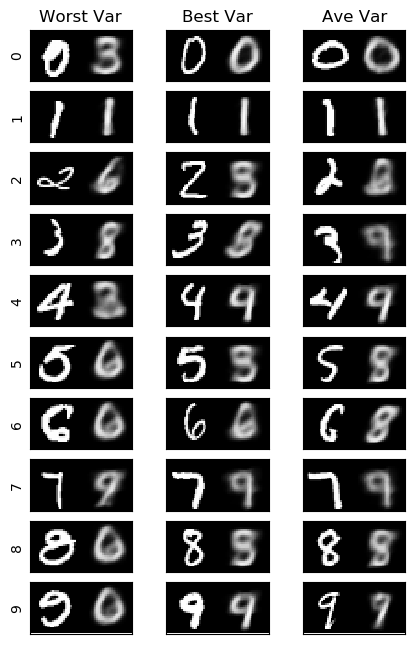

In [283]:
fig, axes = plot_min_max_mean('Var', image_pairs)

image_path = './mnist_images_std_%d_dim.png' %latent_dim
fig.savefig(image_path, bbox_inches='tight')

In [284]:
top = 10
(z_mean_min, z_mean_max), (z_std_min, z_std_max) = get_z_min_max(
    x_train, 
    y_train, 
    df_elbos['elbo'], 
    df_elbos['elbo_var'], 
    enc_model,
    top
)

## ELBO vs VAR

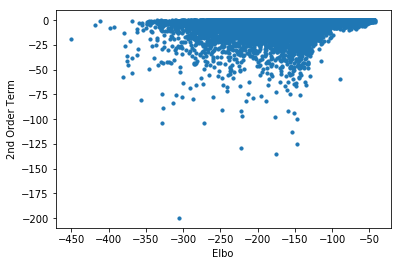

In [285]:
scatter(df_elbos['elbo'], df_elbos['elbo_var'], s = 10)
xlabel('Elbo')
ylabel('2nd Order Term')

gcf().savefig('elbo_v_std_%d_dim.png' %latent_dim, bbox_inches='tight')

# 2D latent space graphs

## Distribution

In [148]:
# calculate the average distributions of the posterior over our latent_dim
dist_ims = []

if latent_dim == 2:
    z_mean, log_z_var = enc_model.predict(x_train)
    z_std = np.exp(log_z_var/2)
    
    z1 = linspace(-4, 4, 100)
    z2 = linspace(-4, 4, 100)

    Z1, Z2 = meshgrid(z1, z2)
    
    for num in range(10):
        idx = argwhere(y_train == num)[:, 0]

        z_mean_num = z_mean[idx]
        z_std_num = z_std[idx]

        n = len(z_mean_num)

        z_dist = 1/n * sum([
            1/sqrt(z_std_num[i, 0]) * exp(-(Z1-z_mean_num[i, 0])**2/(2*z_std_num[i, 0]**2))
            * 1/sqrt(z_std_num[i, 1]) * exp(-(Z2-z_mean_num[i, 1])**2/(2*z_std_num[i, 1]**2))
            for i in range(n)
        ], axis=0)
        
        dist_ims.append(z_dist)

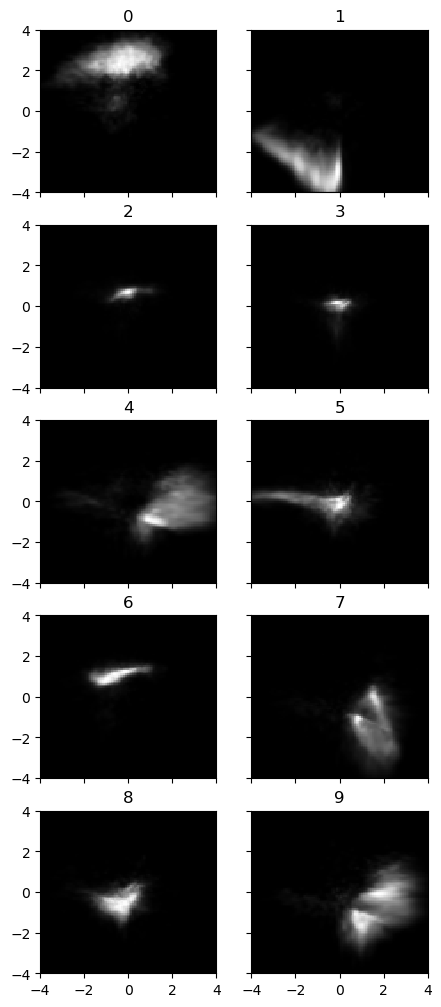

In [149]:
# display distributions of our values

if latent_dim == 2:
    fig, axes = subplots(5, 2, figsize = (5,5/2*5), dpi=100, sharex=True, sharey=True)

    for i in range(5):
        for j in range(2):
            num = 2*i + j
            
            z_dist = dist_ims[num]

            axes[i, j].pcolormesh(Z1, Z2, z_dist, cmap='Greys_r')
            axes[i, j].set_title(num)
    
        
    image_path = './latent_space.png'
    fig.savefig(image_path, bbox_inches='tight')

## Mean

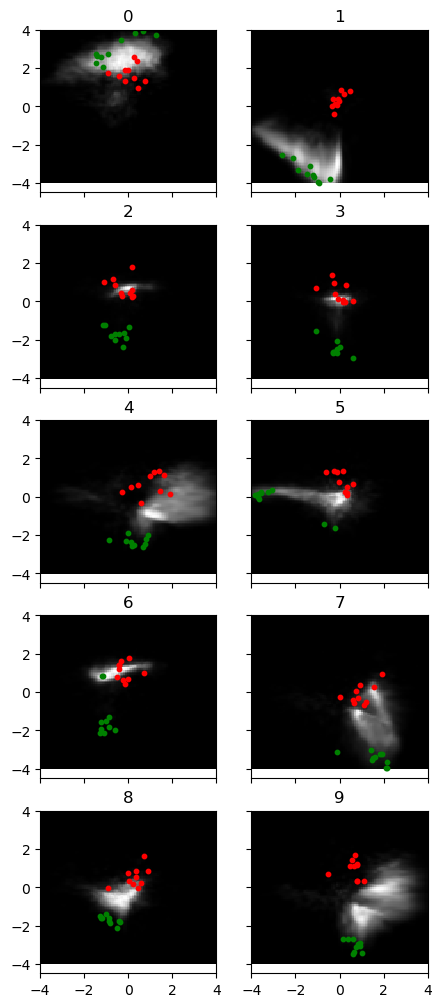

In [150]:
# display data points with a low/high elbo

if latent_dim == 2:
    fig, axes = subplots(5, 2, figsize = (5,5/2*5), dpi=100, sharex=True, sharey=True)

    for i in range(5):
        for j in range(2):
            num = 2*i + j
            
            z_dist = dist_ims[num]

            axes[i, j].pcolormesh(Z1, Z2, z_dist, cmap='Greys_r')
            axes[i, j].scatter(z_mean_min[num][:, 0], z_mean_min[num][:, 1], c='r', s=10)
            axes[i, j].scatter(z_mean_max[num][:, 0], z_mean_max[num][:, 1], c='g', s=10)
            axes[i, j].set_title(num)
            
    image_path = './latent_space_elbo_top_%d.png' %top
    fig.savefig(image_path, bbox_inches='tight')

## Second order term

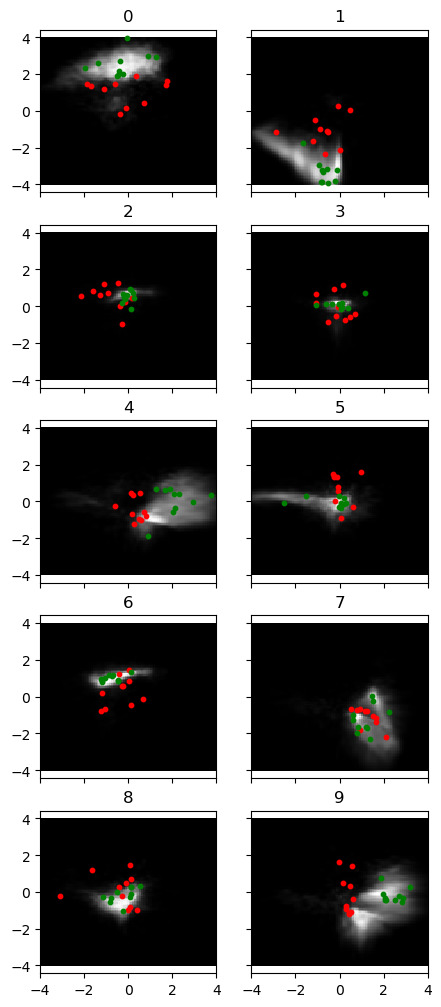

In [151]:
# display data points with low/high second order terms

if latent_dim == 2:    
    fig, axes = subplots(5, 2, figsize = (5,5/2*5), dpi=100, sharex=True, sharey=True)

    for i in range(5):
        for j in range(2):
            num = 2*i + j
            
            z_dist = dist_ims[num]

            axes[i, j].pcolormesh(Z1, Z2, z_dist, cmap='Greys_r')
            axes[i, j].scatter(z_std_min[num][:, 0], z_std_min[num][:, 1], c='r', s=10)
            axes[i, j].scatter(z_std_max[num][:, 0], z_std_max[num][:, 1], c='g', s=10)
            axes[i, j].set_title(num)
            
    image_path = './latent_space_std_top_%d.png' %top
    fig.savefig(image_path, bbox_inches='tight')

## Testing data

In [152]:
# redefine the z_mean and log_z_var variables as numpy arrays
x_test_preds, z_test_samples = get_mc_samples(dec_model, enc_model, x_test)

In [153]:
# save the elbo table
file_path = './mnist_elbos_%d_dim_test.csv' %latent_dim

elbos = elbo(x_test, x_test_preds, enc_model)
df_elbos_test = pd.DataFrame(elbos, columns=['elbo'])
df_elbos_test.to_csv(file_path)
    
y_test_df = pd.DataFrame(y_test, columns=['label'])

mean(elbos)

nan

In [167]:
# calculate the V values for our samples
V_test = calc_V(enc_model, x_test, x_test_preds, z_test_samples)
V_test_var = -1/2 * np.var(V_test, axis=0, ddof=1)

df_elbos_test['elbo_var'] = V_test_var

In [168]:
elbo_labels = []

for num in range(10):
    idx = y_test_df[y_test_df['label'] == num].index
    df_nums = df_elbos_test.iloc[idx, 0]
    elbo_min = df_nums.min()
    elbo_max = df_nums.max()
    elbo_mean = mean(df_nums)
    
    df_std = df_elbos_test.iloc[idx, 1]
    std_min = df_std.min()
    std_max = df_std.max()
    std_mean = mean(df_std)
    elbo_labels.append([elbo_min, elbo_max, elbo_mean, std_min, std_max, std_mean])

# indices represent the number
df_elbo_test_labels = pd.DataFrame(
    elbo_labels, columns=['Worst Elbo', 'Best Elbo', 'Mean Elbo', 'Worst Var', 'Best Var', 'Mean Var']
)

In [169]:
df_elbo_test_labels

,Worst Elbo,Best Elbo,Mean Elbo,Worst Var,Best Var,Mean Var
0,-366.693933,-114.381912,-173.482197,0.009042,150.553568,6.233654
1,-257.876172,-41.784879,-67.177108,0.016249,61.443845,1.932718
2,-375.164260,-131.429058,-198.055739,0.010380,142.562983,5.962771
3,-335.120858,-104.354883,-172.396414,0.012321,154.583823,4.720731
4,-317.110849,-98.891507,-162.760530,0.016533,334.705728,10.441229
5,-333.039472,-98.248522,-175.517422,0.012246,237.972780,6.631310
6,-340.703674,-100.471334,-161.705024,0.005273,105.677376,4.501775
7,-314.934177,-71.321372,-144.836454,0.012003,343.972867,8.774153
8,-366.560294,-106.108475,-174.874663,0.014217,113.685827,5.981424
9,-367.865785,-90.685728,-140.793415,0.009378,175.662396,7.419601


In [170]:
(z_test_mean_min, z_test_mean_max), (z_test_std_min, z_test_std_max) = get_z_min_max(
    x_test, 
    y_test, 
    df_elbos_test['elbo'], 
    df_elbos_test['elbo_var'], 
    enc_model)

## Mean

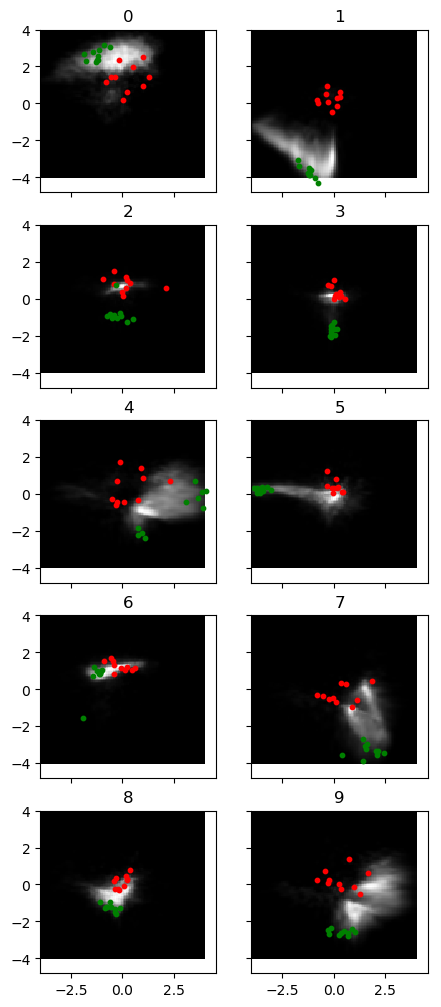

In [171]:
# display data points with a low/high elbo

if latent_dim == 2:
    fig, axes = subplots(5, 2, figsize = (5,5/2*5), dpi=100, sharex=True, sharey=True)

    for i in range(5):
        for j in range(2):
            num = 2*i + j
            
            z_dist = dist_ims[num]

            axes[i, j].pcolormesh(Z1, Z2, z_dist, cmap='Greys_r')
            axes[i, j].scatter(z_test_mean_min[num][:, 0], z_test_mean_min[num][:, 1], c='r', s=10)
            axes[i, j].scatter(z_test_mean_max[num][:, 0], z_test_mean_max[num][:, 1], c='g', s=10)
            axes[i, j].set_title(num)
            
    image_path = './latent_space_elbo_top_%d_test.png' %top
    fig.savefig(image_path, bbox_inches='tight')

## Std

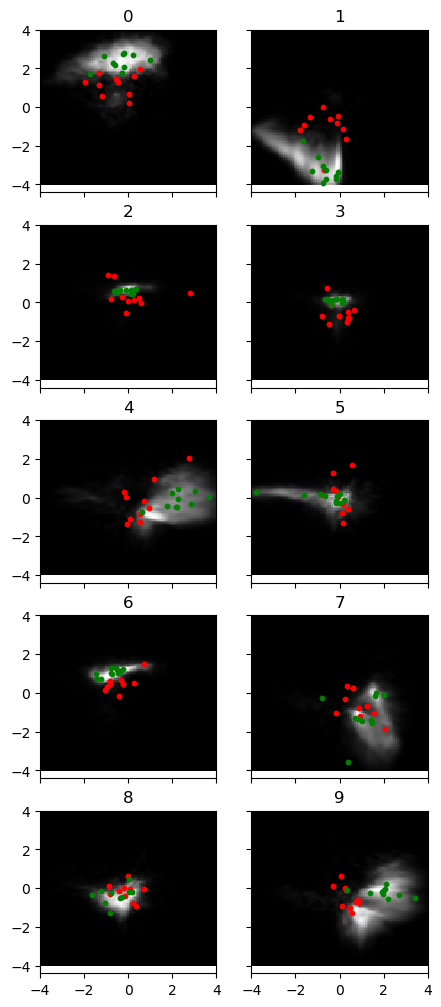

In [172]:
# display data points with low/high second order terms

if latent_dim == 2:    
    fig, axes = subplots(5, 2, figsize = (5,5/2*5), dpi=100, sharex=True, sharey=True)

    for i in range(5):
        for j in range(2):
            num = 2*i + j
            
            z_dist = dist_ims[num]

            axes[i, j].pcolormesh(Z1, Z2, z_dist, cmap='Greys_r')
            axes[i, j].scatter(z_test_std_min[num][:, 0], z_test_std_min[num][:, 1], c='r', s=10)
            axes[i, j].scatter(z_test_std_max[num][:, 0], z_test_std_max[num][:, 1], c='g', s=10)
            axes[i, j].set_title(num)
            
    image_path = './latent_space_std_top_%d_test.png' %top
    fig.savefig(image_path, bbox_inches='tight')